In [47]:
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import biodatatools
import pybedtools
import itertools
import matplotlib.patches as mpatches

In [30]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [31]:
PROJECT_DIR_d = "/home/kl945/EnhancerAtlas/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# TRE categories

In [40]:
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = ["intergenic", "intragenic"]

In [42]:
peak_files = {}
for p in ps:
	p2 = p if p == "divergent" else "unidirectional-no-divergent"
	for d in ds:
		if d == "proximal":
			peak_files[(p, d)] = f"{PROJECT_DIR_d}PROcap/Peaks/PINTS/Merged/20250905_raw_merged-1bp_{p2}_peaks_{d}.bed.bgz"
		else:
			for g in gs:
				peak_files[(p, d, g)] = f"{PROJECT_DIR_d}PROcap/Peaks/PINTS/Merged/20250905_raw_merged-1bp_{p2}_peaks_{d}_{g}.bed.bgz"

In [37]:
counts = {}
for k in peak_files:
	counts[k] = len(pybedtools.BedTool(peak_files[k]))

In [38]:
counts

{('divergent', 'distal', 'intergenic'): 75588,
 ('divergent', 'distal', 'intragenic'): 172612,
 ('divergent', 'proximal'): 61184,
 ('unidirectional', 'distal', 'intergenic'): 101015,
 ('unidirectional', 'distal', 'intragenic'): 266019,
 ('unidirectional', 'proximal'): 38878}

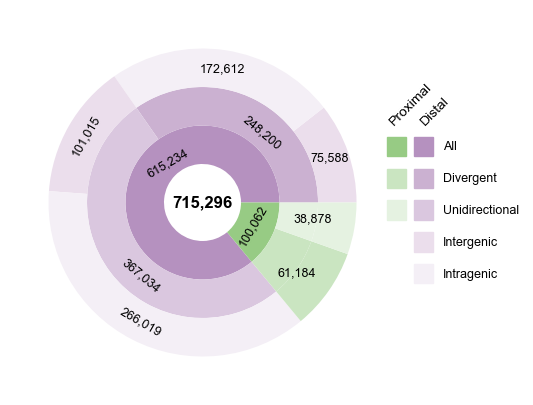

In [96]:
fig, ax = plt.subplots(figsize=(5,5))
size = 0.25

inner = np.array([np.sum([counts[k] for k in counts if d in k]) for d in ds])
middle = np.array([np.sum([counts[k] for k in counts if d in k and p in k]) for d, p in itertools.product(ds, ps)])
cs = []
for d in ds:
    if d == "distal":
        for p, g in itertools.product(ps, gs):
            cs.append(counts[(p,d,g)])
    else:
        for p in ps:
            cs.append(counts[(p,d)])
outer = np.array(cs)

wedges_inner, _ = ax.pie(inner, radius=1-size*2, colors=["#B591BF", "#97CB84"],
       wedgeprops=dict(width=size, edgecolor=None))

wedges_middle, _ = ax.pie(middle.flatten(), radius=1-size, colors=["#CBB1D1", "#DAC7DF", "#CAE5C1", "#E5F2E1"],
       wedgeprops=dict(width=size, edgecolor=None))

wedges_outer, _ = ax.pie(outer, radius=1, colors=["#EBDEEC", "#F4EFF6", "#EBDEEC", "#F4EFF6", "#CAE5C1", "#E5F2E1"],
       wedgeprops=dict(width=size, edgecolor=None))

def add_labels(wedges, values, radius_inner, radius_outer, skip_equal=False, compare_values=None):
	r = (radius_inner + radius_outer)/2
	for i, (w, val) in enumerate(zip(wedges, values)):
		if skip_equal and compare_values is not None and val in compare_values:
			continue
		angle = (w.theta2 + w.theta1)/2
		x = np.cos(np.deg2rad(angle)) * r
		y = np.sin(np.deg2rad(angle)) * r
		# Manually adjust the position
		if val == 615234:
			ax.text(x+0.1, y+0.1, f"{val:,}", ha='center', va='center', fontsize=sfontsize, rotation=30)
		elif val in [101015, 100062]:
			ax.text(x, y, f"{val:,}", ha='center', va='center', fontsize=sfontsize, rotation=60)
		elif val == 38878:
			ax.text(x+0.1, y, f"{val:,}", ha='center', va='center', fontsize=sfontsize)
		elif val == 61184:
			ax.text(x+0.1, y-0.1, f"{val:,}", ha='center', va='center', fontsize=sfontsize)
		elif val in [248200, 367034]:
			ax.text(x+0.1, y-0.1, f"{val:,}", ha='center', va='center', fontsize=sfontsize, rotation=-40)
		elif val == 266019:
			ax.text(x, y, f"{val:,}", ha='center', va='center', fontsize=sfontsize, rotation=-30)
		else:
			ax.text(x, y, f"{val:,}", ha='center', va='center', fontsize=sfontsize)

# Add labels
add_labels(wedges_inner, inner, 0, 1-size*1.1)
add_labels(wedges_middle, middle, 1-size*2, 1-size)

# For outer layer, skip labels for proximal elements where middle == outer
add_labels(wedges_outer, outer, 1-size, 1, 
           skip_equal=True, 
           compare_values=middle)

# Add the sum in the center
total = np.sum([counts[k] for k in counts])
ax.text(0, 0, f"{total:,}", ha='center', va='center', fontsize=bfontsize, fontweight="bold")

colors_proximal = ["#97CB84", "#CAE5C1", "#E5F2E1"]
labels_proximal = ["All", "Divergent", "Unidirectional"]
patches_proximal = [mpatches.Patch(color=c, label=l) for c, l in zip(colors_proximal, labels_proximal)]

legend1 = ax.legend(
    handles=patches_proximal,
    loc='upper left',
    bbox_to_anchor=(0.95, 0.7),
    fontsize=sfontsize,
    frameon=False,
    handleheight=2,
    handlelength=1.5,
    labelspacing=1.0
)
ax.add_artist(legend1)
for text in legend1.get_texts():
    text.set_visible(False)

ax.text(1.2, 0.5, "Proximal", rotation=45, ha="left")

colors_distal = ["#B591BF", "#CBB1D1", "#DAC7DF", "#EBDEEC", "#F4EFF6"]
labels_distal = ["All", "Divergent", "Unidirectional", "Intergenic", "Intragenic"]
patches_distal = [mpatches.Patch(color=c, label=l) for c, l in zip(colors_distal, labels_distal)]

legend2 = ax.legend(
    handles=patches_distal,
    loc='upper left',
    bbox_to_anchor=(1.02, 0.7),
    fontsize=sfontsize,
    frameon=False,
    handleheight=2,
    handlelength=1.5,
    labelspacing=1.0
)
ax.text(1.4, 0.5, "Distal", rotation=45, ha="left")

plt.savefig(f"{PROJECT_DIR_o}figures/Fig1c.pdf", bbox_inches="tight")

# Genome-wide distribution

In [26]:
inputfiles = [f"{PROJECT_DIR_d}PROcap/Peaks/PINTS/Merged/20250905_raw_merged-1bp_divergent_peaks.bed.bgz",
			  f"{PROJECT_DIR_d}PROcap/Peaks/PINTS/Merged/20250905_raw_merged-1bp_unidirectional-no-divergent_peaks.bed.bgz",
			  f"{PROJECT_DIR_d}Resources/Gencode/Human/gencode.v37.annotation.genes.gtf.bgz"
			 ]

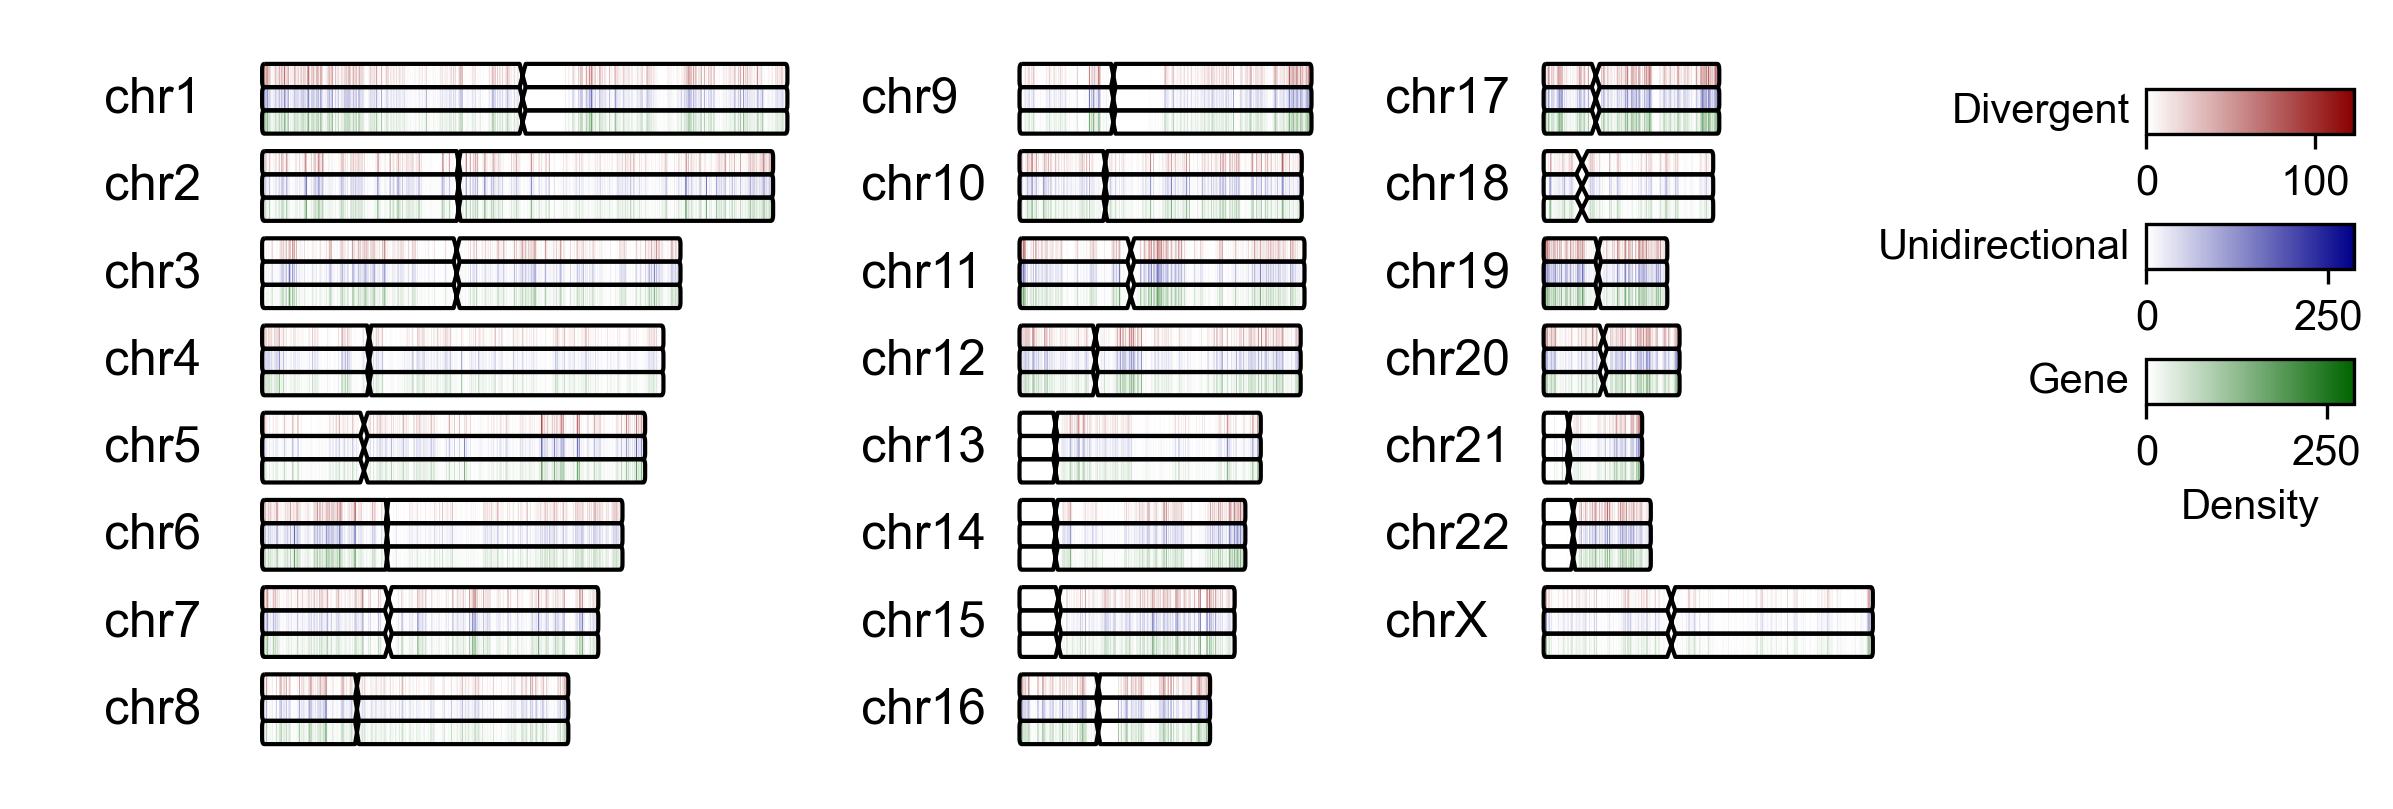

In [27]:
fig = biodatatools.plot_chromosomes_data_regions_density(i=inputfiles, 
														 n=["Divergent", "Unidirectional", "Gene"], 
											g=f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes.filtered.no.chrY.sorted",
											c=f"{PROJECT_DIR_d}Resources/Genome/Human/hg38_centromeres.txt.gz",
											o=None,
											plot_kw={"excluded_chrs": ["chrY"], "ncols": 3, 
													 "textspace": 75000000, "xspace": 110000000,
													 "cbx":1.02, "cby":0.5, "cbw": 0.06, "cbh": 0.1,
													 "scalebar_kw": None,
													 "colormap": {"Divergent": "darkred", 
																  "Unidirectional": "darkblue", 
																  "Gene": "darkgreen"}},
											fig_change_kw={"fig_prop": {"size_inches": [8, 2.8], "dpi": 300},
														   "text_prop": {"fontsize": bfontsize}}
														)
fig.axes[0].get_children()[-4].set_xlabel("Density")
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig1f.png", bbox_inches="tight")